In [2]:
%load_ext autoreload
%autoreload 2
from proj1_helpers import *
from implementations import * 
from cleaning import *
from cross_validation import *
from simulation import *
import matplotlib.pyplot as plt

In [3]:
data_path = "data/train.csv"

In [4]:
y, x, ids = load_csv_data(data_path, sub_sample=False)

## Exploratory Data Analysis

All features are numeric. The number of jets is discrete.

#### Distribution of the features
Let's look at the distribution of some of the features.

In [5]:
def plot_histogram(x, col_idx):
    plt.hist(x[:, col_idx], bins=100, log=True)
    
    plt.title(f'Histogram of feature index {col_idx}')
    plt.ylabel('Counts (log scale)')
    plt.xlabel('Values')
    plt.show()

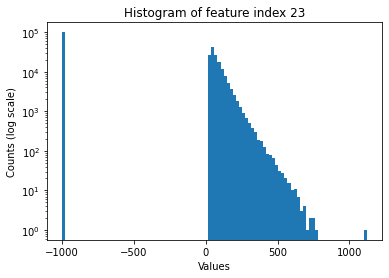

In [6]:
plot_histogram(x, 23)

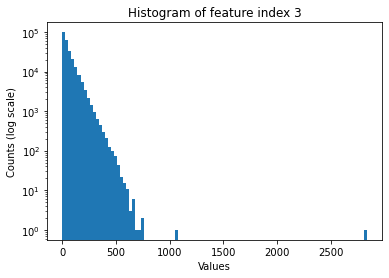

In [7]:
plot_histogram(x, 3)

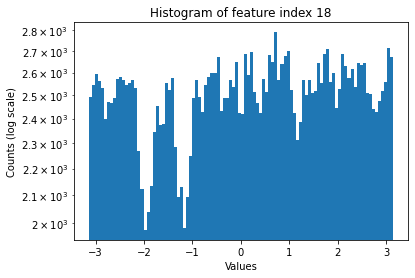

In [8]:
plot_histogram(x, 18)

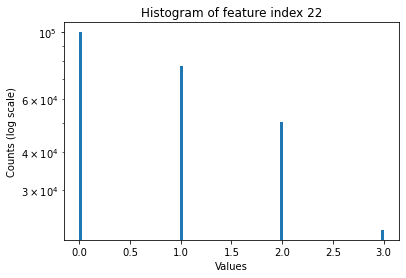

In [9]:
plot_histogram(x, 22)

We can see that some features clearly have default values to -999, some seem to have extreme outliers (e.g. feature 3). We can also check that feature index 22 only has non negative integer values.

#### Check the ranges of some features

In [10]:
# Check if the values for the number of jets are non negative integers
# Column 22 corresponds to this variable
print(f'Number of negative values : {np.sum(x[:, 22] < 0)}')

Number of negative values : 0


In [11]:
x.shape

(250000, 30)

We can see that some of the features have rows with azimuth outside the range. For these features indexes we deciced to put the non-valid values back in the $[-\pi; \pi[$ interval by taking the modulo $2 \pi$ and subtracting $\pi$.

In [12]:
np.sum(x == -999, axis=0)

array([ 38114,      0,      0,      0, 177457, 177457, 177457,      0,
            0,      0,      0,      0, 177457,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,  99913,
        99913,  99913, 177457, 177457, 177457,      0])

We can see that some of the features have a very high number of undefined values (-999). We could replace this undefined values by e.g. 0 or the mean of the remaining values but this would result in columns having its majority of entries (e.g. 177'000 / 250'000 $\approx$ 0.7) at the same value. This would imply that there is not a lot of variance in the feature and therefore this does not give much information about the label we want to predict. So we decided to drop the features where more than half of the rows are at -999.

In [13]:
# We remove the features where more than half of the rows are -999
x_cleaned, col_removed_training = remove_col_default_values(x)

In [14]:
col_removed_training

[4, 5, 6, 12, 26, 27, 28]

Some features represents angles, which are supposed to be in the range $[\pi; -\pi[$ according to the documentation of the dataset (https://higgsml.lal.in2p3.fr/files/2014/04/documentation_v1.8.pdf). Let's check this is the case.

In [15]:
x_cleaned = check_all_azimuth_angles(x_cleaned)

Number of values outside [-pi;pi[ (col 11): 9
Number of values outside [-pi;pi[ (col 14): 11
Number of values outside [-pi;pi[ (col 16): 9
Number of values outside [-pi;pi[ (col 21): 99916


We also looked if some rows were having more than half of its features set to a default value (i.e. -999). In this case, there were no such rows.

In [16]:
check_nb_rows_default_features(x_cleaned)

Number of rows : 0


For the remaining default values, we decided to set them to -999. We did this instead of e.g. replacing them by the mean or median of the remaining values because we noted that the models actually performed better.

In [17]:
x_cleaned, default_values_training = replace_by_default_value(x_cleaned)

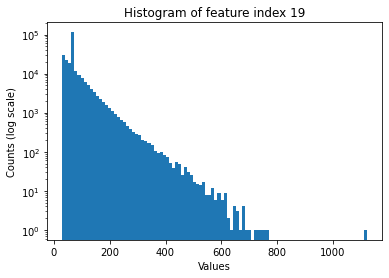

In [18]:
plot_histogram(x_cleaned, 19)

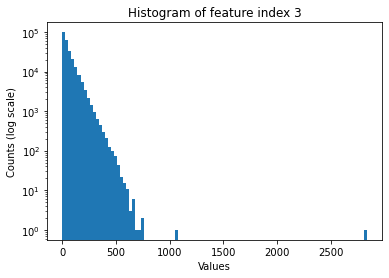

In [19]:
plot_histogram(x_cleaned, 3)

#### Removing outliers
We can observe that in some features there still seems to be some outliers (e.g. see the histogram above for feature index 3).


We will deal with them using a method based on the Inter Quartile Range (IQR). 

In [20]:
x_cleaned, above_lim_training, below_lim_training = clip_IQR(x_cleaned)

Accuracy of reg_logistic_regression on the local test set : 0.6669
F1-score of reg_logistic_regression on the local test set : 0.1240


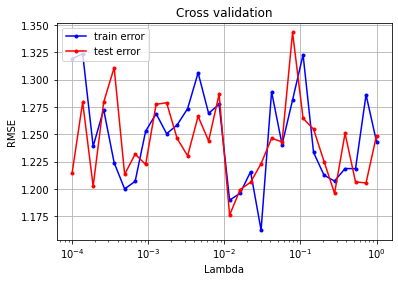

In [41]:
acc_local_test, f1_local_test, w_best = run_experiment(y, x_cleaned, 'reg_logistic_regression', 1, 0.8)

Accuracy of ridge_regression on the local test set : 0.8022
F1-score of ridge_regression on the local test set : 0.6925


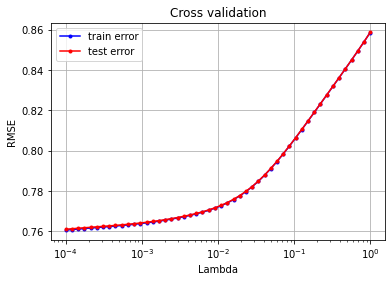

In [22]:
acc_local_test,f1_local_test, w_best = run_experiment(y, x_cleaned, 'ridge_regression', 1, 0.9)

In [29]:
# load and pre-process test data
test_path = 'data/test.csv'
x_te_cleaned, ids_test, y_test = process_test_set(test_path, col_removed_training, default_values_training, above_lim_training, below_lim_training)

Number of values outside [-pi;pi[ (col 11): 19
Number of values outside [-pi;pi[ (col 14): 17
Number of values outside [-pi;pi[ (col 16): 22
Number of values outside [-pi;pi[ (col 21): 227467


In [30]:
# Predict the lab and output the result in the CSV files

#y_test_pred = predict_labels_logistic_regression(w_best, x_test)
y_test_pred = predict_labels(w_best, x_te_cleaned)
create_csv_submission(ids_test, y_test_pred, 'ridge.csv')

## Work on logistic regression